In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

import seaborn as sns

import time
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error

c:\Users\sjy99\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv('data/dataset_collaboration_with_survey_scores.csv')

# Filter the data for project 4
dataset_project_4 = dataset[
    (dataset['project'] == 4) &
    ~(dataset['speaker_id'] == 5) &
    ~(dataset['next_speaker_id'] == 5) &
    (dataset['speaker_id'] == dataset['next_speaker_id'])
    
]

dataset_project_4.head()

,id,project,meeting_number,speaker_number,speech_frequency,total_words,duration,normalized_speech_frequency,speaker_id,next_speaker_id,...,interaction_equality_index,degree_centrality,indegree_centrality,outdegree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,overall_collaboration_score,individual_collaboration_score
80,4_1_SPEAKER_00,4,1,0,1294,12023,1.983333,652.436975,0,0,...,0.330335,0.098437,0.047005,0.051432,0.000022,9.955082e-07,0.000029,0.000013,3.0,4.0
86,4_1_SPEAKER_01,4,1,1,711,12023,1.983333,358.487395,1,1,...,0.330335,0.013715,0.006489,0.007227,0.000011,1.094421e-06,0.000004,0.000003,2.0,2.0
92,4_1_SPEAKER_02,4,1,2,600,12023,1.983333,302.521008,2,2,...,0.330335,0.014887,0.008789,0.006098,0.000018,1.087450e-06,0.000005,0.000003,3.0,3.0
98,4_1_SPEAKER_03,4,1,3,8844,12023,1.983333,4459.159664,3,3,...,0.330335,0.141710,0.072157,0.069553,0.000000,3.286423e-07,0.000031,0.000020,3.0,7.0
104,4_1_SPEAKER_04,4,1,4,574,12023,1.983333,289.411765,4,4,...,0.330335,0.020269,0.010069,0.010200,0.000000,5.897397e-07,0.000006,0.000004,2.0,3.0


In [3]:
dataset_project_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 80 to 383
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              60 non-null     object 
 1   project                         60 non-null     int64  
 2   meeting_number                  60 non-null     int64  
 3   speaker_number                  60 non-null     int64  
 4   speech_frequency                60 non-null     int64  
 5   total_words                     60 non-null     int64  
 6   duration                        60 non-null     float64
 7   normalized_speech_frequency     60 non-null     float64
 8   speaker_id                      60 non-null     int64  
 9   next_speaker_id                 60 non-null     int64  
 10  count                           60 non-null     int64  
 11  network_density                 60 non-null     float64
 12  weighted_network_density        60 non-nu

In [4]:
features = dataset_project_4.drop(
    columns=['individual_collaboration_score', 'id', 'speaker_number',  'project'])
target = dataset_project_4['individual_collaboration_score']
X_train_coll, X_test_coll, y_train_coll, y_test_coll = train_test_split(
    features, target, test_size=0.3, random_state=42)

In [5]:
regression_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'LightGBM Regressor': LGBMRegressor(random_state=42, verbose=-1),
    'CatBoost Regressor': CatBoostRegressor(random_state=42, verbose=0),
    'SVM Regressor': SVR()
}
param_grids_regression = {
    'Linear Regression': {},
    'Decision Tree': {'model__max_depth': [3, 5, 7]},
    'Random Forest Regressor': {'model__n_estimators': [50, 100, 150], 'model__max_depth': [5, 10, 15]},
    'XGBRegressor': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, 7], 'model__learning_rate': [0.01, 0.1, 0.2]},
    'Gradient Boosting Regressor': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5], 'model__learning_rate': [0.01, 0.1, 0.2, 0.5]},
    'K-Nearest Neighbors Regressor': {'model__n_neighbors': [3, 5, 7]},
    'LightGBM Regressor': {'model__n_estimators': [50, 100, 200], 'model__num_leaves': [31, 62,], 'model__learning_rate': [0.01, 0.1, 0.3]},
    'CatBoost Regressor': {'model__iterations': [100, 200, 400], 'model__depth': [4, 6, 10]},
    'SVM Regressor': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']}
}

In [6]:
def find_best_hyperparameters_regression(X_train, y_train, X_test, y_test):
    alpha = 0.35  # Weight for the performance metric (adjust as necessary)
    beta = 0.33
    gamma = 0.3

    # We seek to minimize MSE, so we start with infinity
    best_performance = -float('inf')
    best_model_info = {}
    model_performance = {}

    for model_name, model in regression_models.items():
        start_time = time.time()
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        grid = GridSearchCV(
            pipeline, param_grids_regression[model_name], cv=3, scoring='r2')
        grid.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time

        y_pred = grid.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)
        cv_scores = cross_val_score(
            grid.best_estimator_, X_train, y_train, cv=kf, scoring='r2')
        mean_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)

        performance = alpha * (r2) + gamma*(mean_cv_score) + beta * \
            (1/mse) + (1 - alpha-beta-gamma)

        print(f'{model_name}: R2 = {r2:.3f},MSE = {mse:.3f}, CV Mean = {mean_cv_score:.3f} ± {std_cv_score:.3f}, Training Time: {training_time:.3f} seconds, Best Params: {grid.best_params_}')

        model_performance[model_name] = {
            'performance': performance, 'r2': r2, 'mse': mse, 'cv_mean': mean_cv_score, 'cv_std': std_cv_score, 'training_time': training_time, 'params': grid.best_params_}

        if performance > best_performance:
            best_performance = performance
            best_model_info = {'model': model_name, 'r2': r2, 'mse': mse, 'cv_mean_r2': mean_cv_score, 'cv_std_r2': std_cv_score,
                               'params': grid.best_params_, 'model_object': grid.best_estimator_}

    print(
        f'Best Regression Model overall considering performance and training time: {best_model_info["model"]} with Mean CV R2 Score = {best_model_info["cv_mean_r2"]:.3f}')
    return best_model_info

In [7]:
best_reg_model_info = find_best_hyperparameters_regression(
    X_train_coll, y_train_coll, X_test_coll, y_test_coll
)
best_reg_model_info

Linear Regression: R2 = 0.724,MSE = 0.954, CV Mean = -67.913 ± 200.210, Training Time: 0.032 seconds, Best Params: {}
Decision Tree: R2 = 0.729,MSE = 0.937, CV Mean = -1.379 ± 1.893, Training Time: 0.041 seconds, Best Params: {'model__max_depth': 3}
Random Forest Regressor: R2 = 0.678,MSE = 1.115, CV Mean = -0.370 ± 1.449, Training Time: 2.020 seconds, Best Params: {'model__max_depth': 5, 'model__n_estimators': 50}
XGBRegressor: R2 = 0.744,MSE = 0.884, CV Mean = -0.488 ± 1.198, Training Time: 1.574 seconds, Best Params: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 50}
Gradient Boosting Regressor: R2 = 0.717,MSE = 0.980, CV Mean = -0.589 ± 1.529, Training Time: 1.592 seconds, Best Params: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}


c:\Users\sjy99\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\sjy99\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


K-Nearest Neighbors Regressor: R2 = 0.712,MSE = 0.996, CV Mean = -0.361 ± 1.800, Training Time: 0.255 seconds, Best Params: {'model__n_neighbors': 5}
LightGBM Regressor: R2 = 0.177,MSE = 2.848, CV Mean = -1.308 ± 2.475, Training Time: 0.477 seconds, Best Params: {'model__learning_rate': 0.01, 'model__n_estimators': 50, 'model__num_leaves': 31}
CatBoost Regressor: R2 = 0.802,MSE = 0.685, CV Mean = -0.159 ± 1.564, Training Time: 6.382 seconds, Best Params: {'model__depth': 4, 'model__iterations': 100}
SVM Regressor: R2 = 0.669,MSE = 1.146, CV Mean = -0.324 ± 2.097, Training Time: 0.085 seconds, Best Params: {'model__C': 10, 'model__kernel': 'rbf'}
Best Regression Model overall considering performance and training time: CatBoost Regressor with Mean CV R2 Score = -0.159


{'model': 'CatBoost Regressor',
 'r2': 0.8019146107614978,
 'mse': 0.6853509917788917,
 'cv_mean_r2': -0.15914122530687977,
 'cv_std_r2': 1.5637715619528543,
 'params': {'model__depth': 4, 'model__iterations': 100},
 'model_object': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model',
                  <catboost.core.CatBoostRegressor object at 0x00000191F0557760>)])}

Mean Squared Error: 0.685
R^2 Score: 0.802


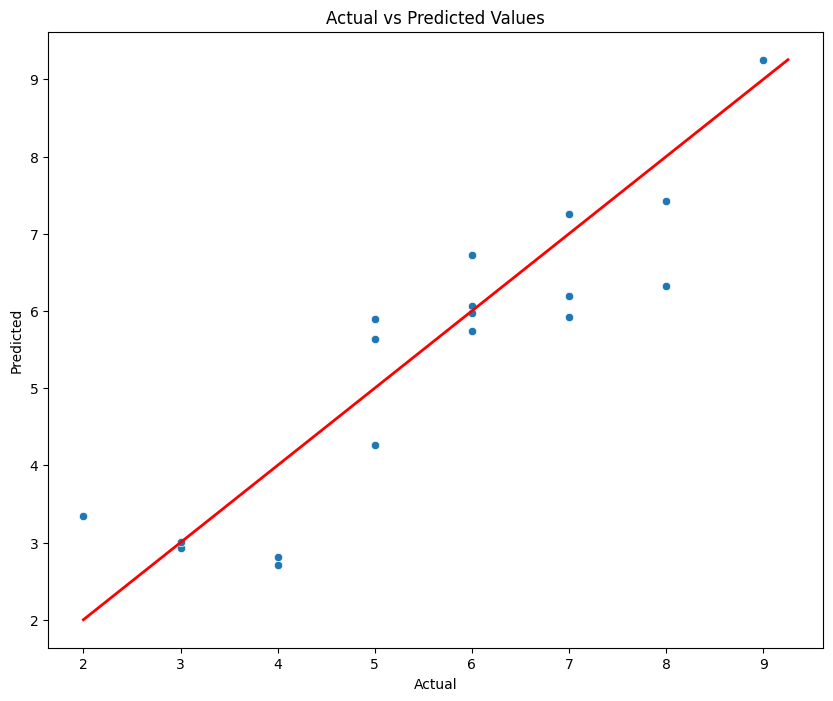

,meeting_number,speech_frequency,total_words,duration,normalized_speech_frequency,speaker_id,next_speaker_id,count,network_density,weighted_network_density,...,degree_centrality,indegree_centrality,outdegree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,pagerank,overall_collaboration_score,Actual,Predicted
0,1,1294,12023,1.983333,652.436975,0,0,1,0.80,0.164643,...,0.098437,0.047005,0.051432,0.000022,9.955082e-07,2.854199e-05,1.293119e-05,3.0,4.0,2.811935
1,2,1894,11416,2.116667,894.803150,0,0,8,0.90,0.218186,...,0.067101,0.032509,0.034592,0.000000,2.777950e-06,1.730961e-05,8.422470e-06,3.0,3.0,2.922985
2,8,1139,12731,2.266667,502.500000,1,1,0,1.00,0.136120,...,0.030255,0.015371,0.014884,0.000000,5.009113e-08,1.012910e-06,6.464204e-07,7.0,6.0,6.059164
3,10,2824,15725,2.733333,1033.170732,0,0,6,0.95,0.151823,...,0.105738,0.054988,0.050750,0.000000,1.040921e-07,5.853565e-06,2.796552e-06,8.0,6.0,5.734860
4,3,4354,9697,1.900000,2291.578947,3,3,19,0.95,0.205633,...,0.185583,0.090027,0.095556,0.000000,7.833045e-08,1.885281e-05,1.246472e-05,2.0,6.0,5.973121
5,11,1086,17883,2.716667,399.754601,4,4,0,1.00,0.116108,...,0.010650,0.005360,0.005290,0.000000,3.466180e-08,1.880733e-07,1.750548e-07,9.0,8.0,7.427297
6,7,7634,8965,1.766667,4321.132075,3,3,1132,0.80,0.050454,...,0.266285,0.132934,0.133351,0.000000,6.215836e-07,6.413093e-05,4.257205e-05,3.0,8.0,6.323911
7,10,9580,15725,2.733333,3504.878049,3,3,30,0.95,0.151823,...,0.136193,0.066198,0.069995,0.000000,6.688950e-08,5.748011e-06,3.655338e-06,7.0,9.0,9.254266
8,3,790,9697,1.900000,415.789474,2,2,4,0.95,0.205633,...,0.017212,0.006867,0.010345,0.000024,4.922602e-07,2.215148e-06,1.621195e-06,3.0,3.0,3.008997
9,12,406,17930,2.700000,150.370370,2,2,0,0.90,0.084132,...,0.001244,0.000694,0.000550,0.000002,1.909801e-07,4.452221e-08,1.585724e-07,7.0,5.0,5.632536


In [8]:
def predict_and_evaluate(best_reg_model_info, X_train, y_train, X_test, y_test):
    best_model = best_reg_model_info['model_object']
    # Fit the best model on the training data
    best_model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = best_model.predict(X_test)

    # Evaluate the predictions
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse:.3f}')
    print(f'R^2 Score: {r2:.3f}')

    # Create a DataFrame for comparison of actual vs predicted values
    results_df = pd.DataFrame(
        {'Actual': y_test, 'Predicted': y_pred})
    results_with_test_df = pd.concat(
        [X_test.reset_index(drop=True), results_df.reset_index(drop=True)], axis=1)

    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='Actual', y='Predicted', data=results_df)
    plt.plot([results_df.min().min(), results_df.max().max()], [
             results_df.min().min(), results_df.max().max()], color='red', linewidth=2)
    plt.title('Actual vs Predicted Values')
    plt.show()

    return results_with_test_df


# Usage example:
results_df = predict_and_evaluate(
    best_reg_model_info, X_train_coll, y_train_coll, X_test_coll, y_test_coll)
display(results_df)

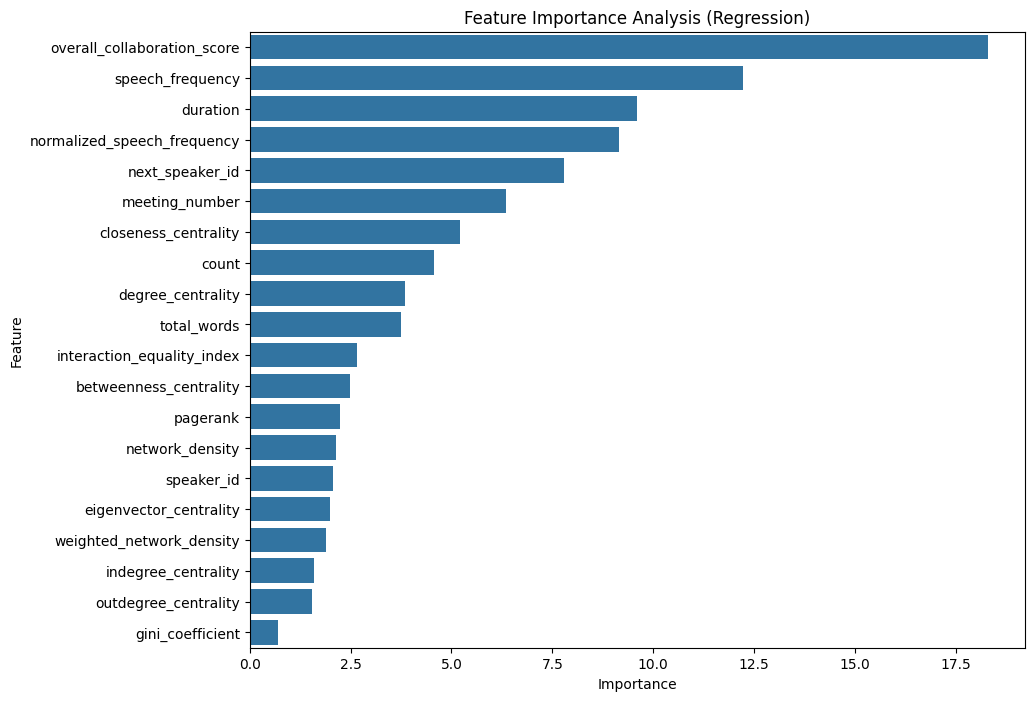

                        Feature  Importance
19  overall_collaboration_score   18.295183
1              speech_frequency   12.228441
3                      duration    9.602477
4   normalized_speech_frequency    9.159726
6               next_speaker_id    7.797507
0                meeting_number    6.346276
16         closeness_centrality    5.201733
7                         count    4.554617
12            degree_centrality    3.837213
2                   total_words    3.737838


In [9]:
# Check if the best model has feature importances and plot them
if hasattr(best_reg_model_info['model_object'].named_steps['model'], 'feature_importances_'):
    # Extract feature importance
    best_model = best_reg_model_info['model_object'].named_steps['model']
    feature_importances_reg = best_model.feature_importances_

    # Create a DataFrame for visualization
    importance_df_reg = pd.DataFrame(
        {'Feature': X_train_coll.columns, 'Importance': feature_importances_reg})
    importance_df_reg = importance_df_reg.sort_values(
        by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df_reg)
    plt.title('Feature Importance Analysis (Regression)')
    plt.show()

    print(importance_df_reg.head(10))
else:
    print('No feature importances available for this model.')